# Create a forward operator and display sensitivity maps

`
Authors: Eric Larson <larson.eric.d@gmail.com>
         Denis Engemann <denis.engemann@gmail.com>
         Alex Gramfort <alexandre.gramfort@inria.fr>
`

License: BSD (3-clause)

First setup some paths. We will use the MNE sample data.

In [1]:
%matplotlib qt
import matplotlib.pyplot as plt

import os
import mne

# Change the following path to where the folder ds000117-practical is on your disk
data_path = os.path.expanduser("~\\Downloads\\meeg\\ds000117-practical\\")  # this works and is user-independent

raw_fname = os.path.join(data_path,
    'derivatives\\meg_derivatives\\sub-01\\ses-meg\\meg\\sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif')

In [2]:
from IPython.display import Image
from mayavi import mlab

In [3]:
# to check that things work:
# mlab.test_contour3d()

# Computing the forward operator

To compute a forward operator we need:

   - a ``-trans.fif`` file that contains the coregistration info
   - a source space
   - the BEM surfaces

## Compute and visualize BEM surfaces

Symmetric boundary element method (symmetric BEM) uses three realistic layers (scalp, inner skull, outer skull). The goal of this forward solution is mostly for EEG users, to provide more accurate results than the spherical models.

Computing the BEM surfaces requires FreeSurfer and makes use of either of the two following command line tools:

[mne watershed_bem](http://martinos.org/mne/dev/generated/commands.html#mne-watershed-bem)

[mne flash_bem](http://martinos.org/mne/dev/generated/commands.html#mne-flash-bem)

or directly by calling the functions

https://mne.tools/stable/generated/mne.bem.make_watershed_bem.html
https://mne.tools/stable/generated/mne.bem.make_flash_bem.html

Here, we'll assume it's already computed. It takes a few minutes per subject.

So, let's first look at the BEM surfaces.

For EEG we use 3 layers (inner skull, outer skull, and skin), while for MEG 1 layer (inner skull) is enough.

To compute the BEM we'll need to use freesurfer.
You can get it at https://surfer.nmr.mgh.harvard.edu/fswiki/DownloadAndInstall#Download
if you are on mac or linux but you can also use a virtual machine on Windows. See
https://surfer.nmr.mgh.harvard.edu/fswiki/Installation/FreeSurferVirtualImage

To get it in this dataset I did in terminal after setting the SUBJECTS_DIR properly:

    mne watershed_bem -s sub-01 --overwrite
    mne make_scalp_surfaces -s sub-01 --force --overwrite

In [4]:
t1_fname = os.path.join(data_path, 'derivatives\\freesurfer-reconall\\sub-01\\mri\\T1.mgz')

In [5]:
from nilearn import plotting
plotting.plot_anat(t1_fname);
plt.show()

In [6]:
subjects_dir = os.path.join(data_path, 'derivatives\\freesurfer-reconall\\')

In [7]:
mne.viz.plot_bem(subject='sub-01', subjects_dir=subjects_dir,
                 orientation='coronal');

Using surface: C:\Users\egora\Downloads\meeg\ds000117-practical\derivatives\freesurfer-reconall\sub-01\bem\inner_skull.surf
Using surface: C:\Users\egora\Downloads\meeg\ds000117-practical\derivatives\freesurfer-reconall\sub-01\bem\outer_skull.surf
Using surface: C:\Users\egora\Downloads\meeg\ds000117-practical\derivatives\freesurfer-reconall\sub-01\bem\outer_skin.surf


In [ ]:
## causes the kernel to hang
#mne.gui.coregistration(subject='sub-01', subjects_dir=subjects_dir, inst=raw_fname);

    Triangle neighbors and vertex normals...
Coregistration: Excluding 0 head shape points with distance >= inf m.
Coregistration: Excluding 0 head shape points with distance >= inf m.


KeyboardInterrupt: 

### Visualizing the coregistration

The coregistration is the operation that allows to position the head and the sensors in a common coordinate system. In the MNE software, the transformation to align the head and the sensors in stored in a so-called *trans* file. It is a FIF file that ends with `-trans.fif`. It can be obtained with ``mne_analyze`` (Unix tools), ``mne.gui.coregistration`` (in Python) or mrilab if you're using a Neuromag system.

For the Python version, see https://mne.tools/dev/generated/mne.gui.coregistration.html

Here, we assume the coregistration is done, so we just visually check the alignment with the following code.

=====

EA&AA: 

To run from the command line, use something like the following code:
> mne coreg C:\Users\egora\Downloads\meeg\ds000117-practical\derivatives\freesurfer-reconall\ C:\Users\egora\Downloads\meeg\ds000117-practical\deri
vatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif

This doesn't mess with the kernel.

In order to generate the trans.fif file, load the digitization source (raw data: _meg.fif_) and press either Fit Fid. Then you can save using the bottom-right button.

For some pointers, see: https://www.slideshare.net/mne-python/mnepython-coregistration

The bottom-line seems to be that it's hard to obtain a good fit.

In [20]:
#trans_fname = os.path.join(data_path,
#    'derivatives\\meg_derivatives\\sub-01\\ses-meg\\meg\\sub-01-trans.fif')
trans_fname = os.path.join(data_path,
    'derivatives\\meg_derivatives\\sub-01\\ses-meg\\meg\\sub-01-trans2.fif')
info = mne.io.read_info(raw_fname)
fig = mne.viz.plot_alignment(info, trans_fname, subject='sub-01', dig=True,
                             subjects_dir=subjects_dir, verbose=True);

Using outer_skin.surf for head surface.
Getting helmet for system 306m


In [9]:
mlab.close('all')  # doesn't seem to work

C:\Users\egora\Anaconda3\envs\mne\lib\site-packages\mayavi\tools\figure.py:178: UserWarning: Scene all not managed by mlab
  warnings.warn('Scene %s not managed by mlab' % name)


## Compute Source Space

The source space defines the position of the candidate source locations.

The following code computes such a source space with an OCT-6 resolution.

In [16]:
mne.set_log_level('WARNING')
subject = 'sub-01'
src = mne.setup_source_space(subject, spacing='oct6',
                             subjects_dir=subjects_dir,
                             add_dist=False)

In [17]:
src

<SourceSpaces: [<surface (lh), n_vertices=138785, n_used=4098, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=139494, n_used=4098, coordinate_frame=MRI (surface RAS)>]>

``src`` contains two parts, one for the left hemisphere (4098 locations) and one for the right hemisphere (4098 locations).

In [18]:
fig = mne.viz.plot_alignment(info, trans_fname, subject=subject, dig=False, src=src,
                             subjects_dir=subjects_dir, verbose=True, meg=False,
                             eeg=False);

Using outer_skin.surf for head surface.


In [21]:
mne.viz.plot_alignment(info, trans_fname, subject=subject,
                       src=src, subjects_dir=subjects_dir, dig=True,
                       surfaces=['head-dense', 'white'], coord_frame='meg')

In [ ]:
mlab.close()

### Compute forward solution

We can now compute the forward solution.

To reduce computational load, we'll just compute a single layer BEM
(just inner skull) that can then be used for MEG (not EEG).

In [22]:
conductivity = (0.3,)  # for single layer
# conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(subject=subject, ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

In [23]:
bem_fname = os.path.join(data_path,
    'derivatives\\meg_derivatives\\sub-01\\ses-meg\\meg\\sub-01-bem.fif')
mne.bem.write_bem_solution(bem_fname, bem)

In [24]:
fwd = mne.make_forward_solution(raw_fname, trans=trans_fname,
                                src=src, bem=bem,
                                meg=True, # include MEG channels
                                eeg=False, # exclude EEG channels
                                mindist=5.0, # ignore sources <= 5mm from inner skull
                                n_jobs=1) # number of jobs to run in parallel

In [25]:
fwd_fname = os.path.join(data_path,
    'derivatives\\meg_derivatives\\sub-01\\ses-meg\\meg\\sub-01-meg-fwd.fif')
mne.write_forward_solution(fwd_fname, fwd, overwrite=True)

Or read the EEG/MEG file from disk

In [26]:
fwd = mne.read_forward_solution(fwd_fname)

In [27]:
fwd

<Forward | MEG channels: 306 | EEG channels: 0 | Source space: Surface with 8188 vertices | Source orientation: Free>

Convert to surface orientation for cortically constrained inverse modeling:

In [28]:
fwd = mne.convert_forward_solution(fwd, surf_ori=True)
leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)  ## three times the number of vertices -- x, y, z

Leadfield size : 306 sensors x 24564 dipoles


Compute sensitivity maps for gradiometers

In [29]:
sens_map = mne.sensitivity_map(fwd, ch_type='grad', mode='fixed')

# Show gain matrix a.k.a. leadfield matrix with sensitivy map

In [30]:
import matplotlib.pyplot as plt

picks = mne.pick_types(fwd['info'], meg='grad', eeg=False)

im = plt.imshow(leadfield[picks, :500], origin='lower', aspect='auto', cmap='RdBu_r')
plt.xlabel('sources')
plt.ylabel('sensors')
plt.title('Lead field matrix for Gradiometers', fontsize=14)
plt.colorbar(cmap='RdBu_r')

In [31]:
plt.figure()
plt.hist(sens_map.data.ravel(), bins=20, label='Gradiometers',
          color='c')
plt.legend()
plt.title('Normal orientation sensitivity')
plt.xlabel('sensitivity')
plt.ylabel('count');

Let's view in 3D:

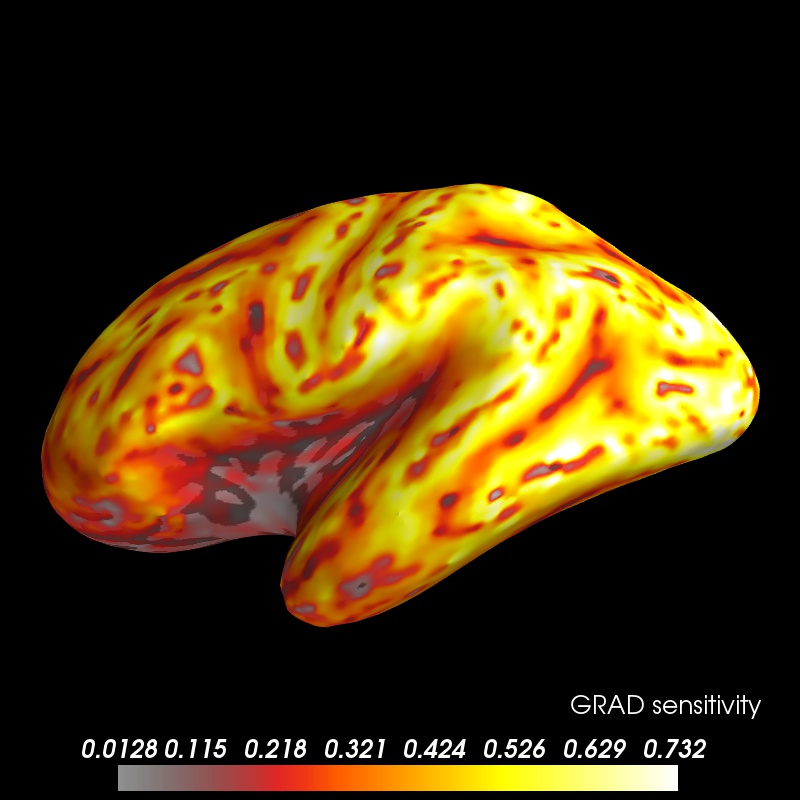

In [32]:
# enable correct backend for 3d plotting
clim = dict(kind='percent', lims=(0.0, 50, 99), smoothing_steps=3)  # let's see single dipoles
brain = sens_map.plot(subject=subject, time_label='GRAD sensitivity',
                      subjects_dir=subjects_dir, clim=clim, smoothing_steps=8);
view = 'lat'
brain.show_view(view)
brain.save_image('sensitivity_map_grad_%s.jpg' % view)
Image(filename='sensitivity_map_grad_%s.jpg' % view, width=400)

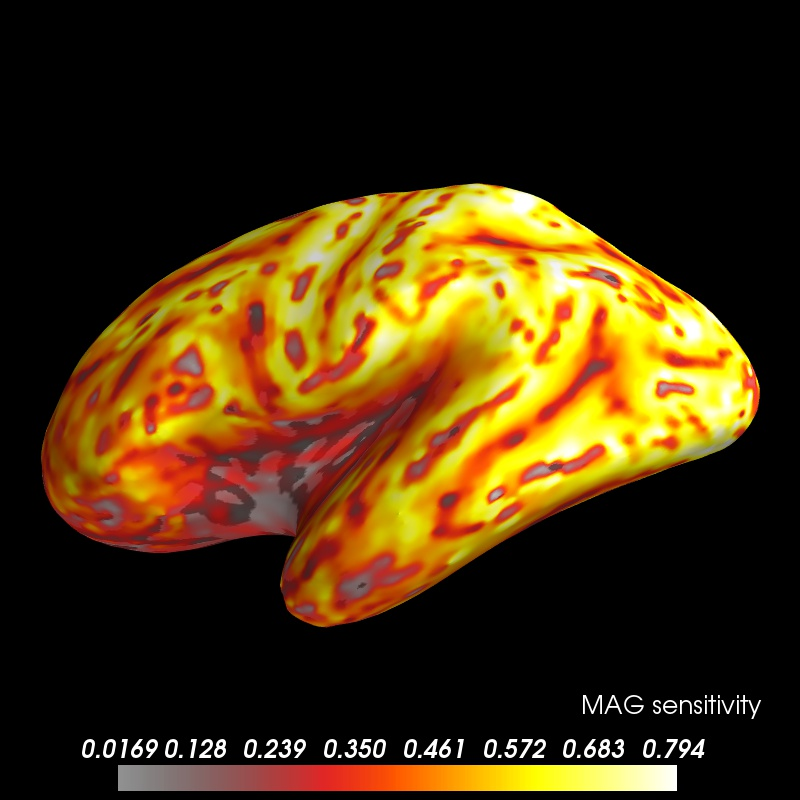

In [34]:
# enable correct backend for 3d plotting
sens_map = mne.sensitivity_map(fwd, ch_type='mag', mode='fixed')
clim = dict(kind='percent', lims=(0.0, 50, 99), smoothing_steps=3)  # let's see single dipoles
brain = sens_map.plot(subject=subject, time_label='MAG sensitivity',
                      subjects_dir=subjects_dir, clim=clim, smoothing_steps=8);
view = 'lat'
brain.show_view(view)
brain.save_image('sensitivity_map_mag_%s.jpg' % view)
Image(filename='sensitivity_map_mag_%s.jpg' % view, width=400)

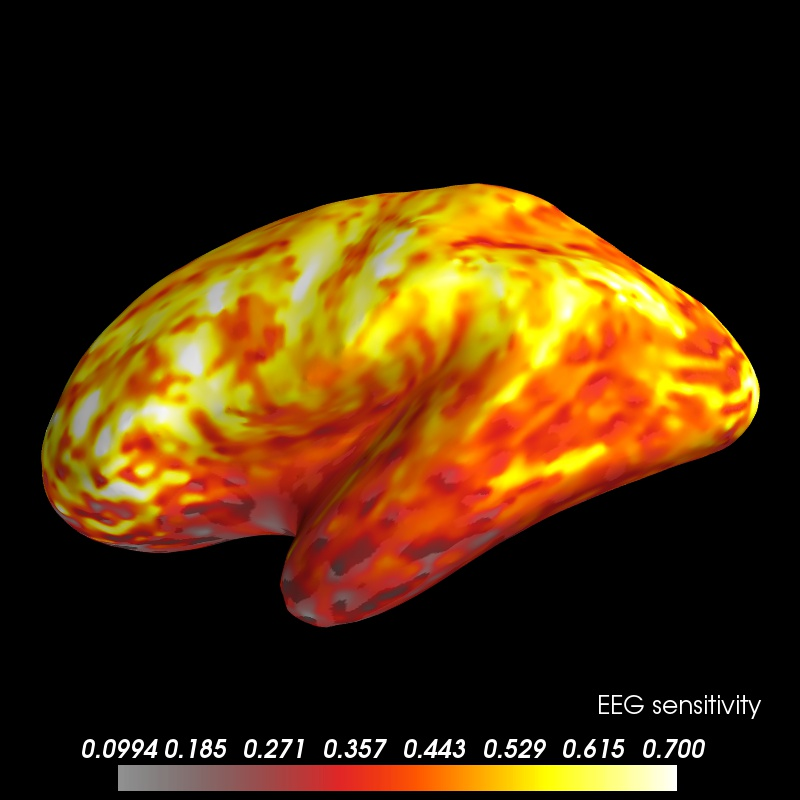

In [36]:
# conductivity = (0.3,)  # for single layer
conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(subject=subject, ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

fwd = mne.make_forward_solution(raw_fname, trans=trans_fname,
                                src=src, bem=bem,
                                meg=False, # exclude MEG channels
                                eeg=True, # include EEG channels
                                mindist=5.0, # ignore sources <= 5mm from inner skull
                                n_jobs=1) # number of jobs to run in parallel

# enable correct backend for 3d plotting
sens_map = mne.sensitivity_map(fwd, ch_type='eeg', mode='fixed')
clim = dict(kind='percent', lims=(0.0, 50, 99), smoothing_steps=3)  # let's see single dipoles
brain = sens_map.plot(subject=subject, time_label='EEG sensitivity',
                      subjects_dir=subjects_dir, clim=clim, smoothing_steps=8);
view = 'lat'
brain.show_view(view)
brain.save_image('sensitivity_map_eeg_%s.jpg' % view)
Image(filename='sensitivity_map_eeg_%s.jpg' % view, width=400)

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compute and plot the sensitivity maps for magnetometers and compare it with the gradiometers. </li>
      <li>Can you justify the claims that MEG is not sensitive to radial sources?</li>     
      <li>Try changing the `mode` parameter in `mne.sensitivity_map` and see how fixed or free orientation forward operator change the pictures. Comment.</li>
    </ul>
</div>